In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path="/content/drive/MyDrive/Grad Project/preprocessed_2.xls"
data =pd.read_csv(path, sep=",", engine="python")
data.head()

,claim_status,phase3_cleaned,lemmas
0,claim,elect donald trump this week but only after o...,elect donald trump this week but only after ...
1,Supported claim,reuters published an article saying berlin the...,reuter publish an article say berlin the germa...
2,opinion,in our opinion humans physically cannot hum wh...,in our opinion human physically can not hum wh...
3,Supported claim,reuters published an article saying kampala ug...,reuter publish an article say kampala ugandan ...
4,opinion,my colleagues think that it is illegal to wast...,my colleague think that it be illegal to waste...


In [4]:
data.dropna(subset=["lemmas", "claim_status"], inplace=True)

In [5]:
X=data['lemmas']
y=data['claim_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

print("X size:", X_train.shape)
print("y size:", X_test.shape)

X size: (30835,)
y size: (13215,)


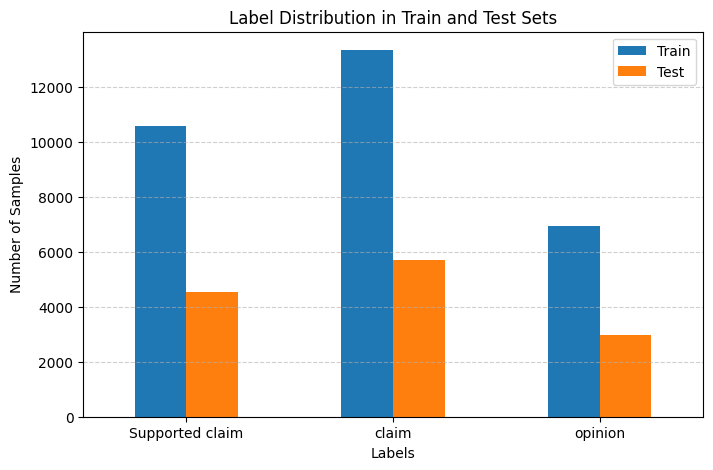

In [6]:
# counting labels
train_counts = pd.Series(y_train).value_counts().sort_index()
test_counts = pd.Series(y_test).value_counts().sort_index()
label_df = pd.DataFrame({
    'Train': train_counts,
    'Test': test_counts
})


label_df.plot(kind='bar', figsize=(8,5))
plt.title('Label Distribution in Train and Test Sets')
plt.xlabel('Labels')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [7]:
tfidf = TfidfVectorizer(
    sublinear_tf=True,
    stop_words="english",
    ngram_range=(1,2),
    max_df=0.9,
    min_df=2
)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

# Train

In [8]:
base_svm = LinearSVC(
    C=10,
    class_weight="balanced",
    random_state=42,
    dual="auto",
    max_iter=1000
)


In [9]:
calibrated_svm = CalibratedClassifierCV(base_svm, cv=5)
calibrated_svm.fit(X_train_tfidf, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=LinearSVC(C=10, class_weight='balanced',
                                           random_state=42))

In [10]:
train_pred = calibrated_svm.predict(X_train_tfidf)
print("Training Accuracy:", accuracy_score(y_train, train_pred))
print(classification_report(y_train, train_pred))

Training Accuracy: 0.9979892978757905
                 precision    recall  f1-score   support

Supported claim       1.00      1.00      1.00     10583
          claim       1.00      1.00      1.00     13328
        opinion       0.99      1.00      1.00      6924

       accuracy                           1.00     30835
      macro avg       1.00      1.00      1.00     30835
   weighted avg       1.00      1.00      1.00     30835



# Test

In [11]:
y_pred = calibrated_svm.predict(X_test_tfidf)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



Test Accuracy: 0.985017026106697
                 precision    recall  f1-score   support

Supported claim       1.00      1.00      1.00      4535
          claim       0.98      0.98      0.98      5712
        opinion       0.97      0.98      0.97      2968

       accuracy                           0.99     13215
      macro avg       0.98      0.98      0.98     13215
   weighted avg       0.99      0.99      0.99     13215



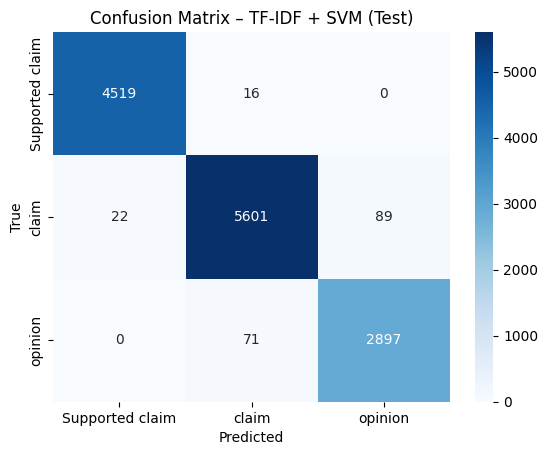

In [12]:
cm = confusion_matrix(y_test, y_pred, labels=calibrated_svm.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=calibrated_svm.classes_, yticklabels=calibrated_svm.classes_)
plt.title("Confusion Matrix – TF-IDF + SVM (Test)")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

# Scores

In [13]:
proba = calibrated_svm.predict_proba(X_test_tfidf)
confidence = np.max(proba, axis=1) * 100
pred_labels = calibrated_svm.classes_[np.argmax(proba, axis=1)]

In [14]:
cred_weights = {"opinion": 0.3, "claim": 0.6, "Supported claim": 0.9}

In [15]:
results = []
for i, label in enumerate(y_pred):
    conf = confidence[i] / 100
    base = cred_weights[label]
    credibility = round(conf * base * 100, 2)
    results.append({
        "Text": X_test.iloc[i][:120] + "...",
        "True Label": y_test.iloc[i],
        "Predicted": label,
        "Confidence (%)": round(conf * 100, 2),
        "Credibility (%)": credibility
    })

results_df = pd.DataFrame(results)

In [16]:
print("\nSample Predictions with Scores:\n")
results_df.head(10)


Sample Predictions with Scores:



,Text,True Label,Predicted,Confidence (%),Credibility (%)
0,accord to reuters vienna russian foreign minis...,Supported claim,Supported claim,99.97,89.98
1,a report from reuter reveal that taipei china ...,Supported claim,Supported claim,99.53,89.57
2,reuters say that johannesburg leader of zimbab...,Supported claim,Supported claim,99.93,89.94
3,my colleague impression be that our sense of...,opinion,opinion,99.69,29.91
4,our hypothesis be that there be more star in t...,opinion,opinion,99.90,29.97
5,it blow my mind when I learn the large prime n...,claim,claim,99.97,59.98
6,reuter publish an article say dakar lome the l...,Supported claim,Supported claim,99.99,90.00
7,my friend position be that mar have run wate...,opinion,opinion,100.00,30.00
8,war peace but draw sharp criticism over allege...,claim,claim,99.37,59.62
9,source link bit ly jbh lu bit ly jpe...,claim,claim,98.80,59.28


# Saving

In [ ]:
joblib.dump(calibrated_svm, "faktz_final_model.pkl")
joblib.dump(tfidf, "faktz_tfidf_vectorizer.pkl")

print("\nModel and vectorizer saved successfully.")